# Change Detection in Sentinel-1 Data

In [1]:
import nd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

## Reading data

For this example we are looking at a small area in Kalimantan, Indonesia.
The data set is a monthly time series of Sentinel-1 C-band SAR data for 2017 to 2018.

We also include a reference deforestation data set from [GlobalForestWatch](http://globalforestwatch.org/).

In [3]:
ds = xr.open_dataset('s1_kalimantan_2017_18.nc')
# Reference forest map
forest = xr.open_dataset('kalimantan_forest.nc')

To get a quick sense of the data, the following four plots show RGB visualizations of the data at the beginning and end of the time series, as well as the annual mean for 2017 and 2018.

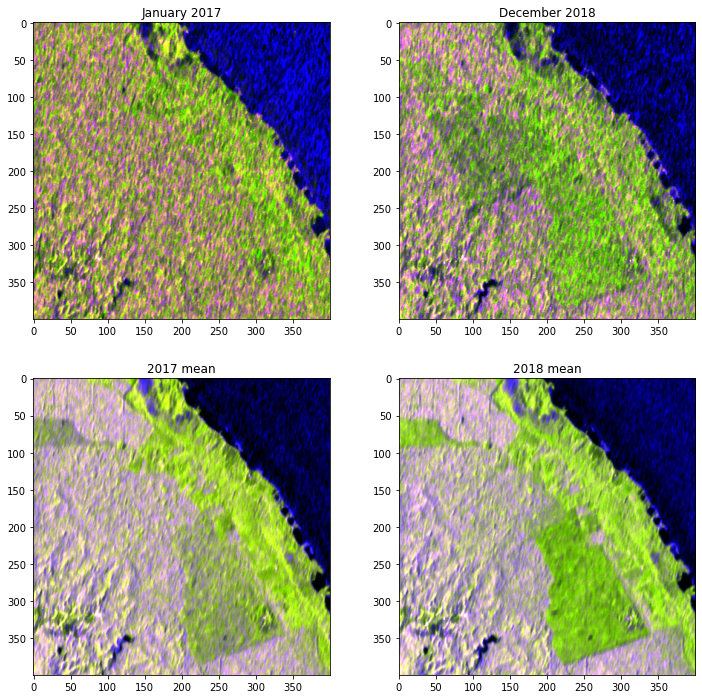

In [4]:
im17 = ds.sel(time='2017').mean('time').nd.to_rgb()
im18 = ds.sel(time='2018').mean('time').nd.to_rgb()
im_start = ds.isel(time=0).nd.to_rgb()
im_end = ds.isel(time=-1).nd.to_rgb()
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].imshow(im_start)
ax[0, 0].set_title('January 2017')
ax[0, 1].imshow(im_end)
ax[0, 1].set_title('December 2018')
ax[1, 0].imshow(im17)
ax[1, 0].set_title('2017 mean')
ax[1, 1].imshow(im18)
ax[1, 1].set_title('2018 mean');

We can also look at a video of the data to see the the temporal evolution:

In [5]:
ds.nd.to_video('s1_kalimantan.gif', fps=6, fontcolor=(255, 255, 255), width=300)

<img src="s1_kalimantan.gif" align="left">

## Filtering

We can now apply some filtering to reduce speckle and other noise. In this case we use a non-local means filter:

In [6]:
N = 50
ds_nlm = ds.filter.nlmeans(dims=('time', 'y', 'x'), r=(1, 3, 3), n_eff=N)
ds_nlm.nd.to_video('s1_kalimantan_nlm.gif', fps=6, fontcolor=(255, 255, 255), width=300)

The filtered (smoothed) dataset is shown below.

<!-- <img src="s1_kalimantan.gif" align="left"><div/> -->
<img src="s1_kalimantan_nlm.gif" align="left">

## Change Detection

We will now perform a change detection over this data set, using the Omnibus test for time series of polarimetric SAR data [1].

In [7]:
change = ds_nlm.nd.change_omnibus(n=N, alpha=1e-4)

The output will highlight pixels at time steps where a change was detected at the specified significance level.

In [8]:
change.nd.to_video('kalimantan_change.gif', fps=6, fontcolor=(255, 0, 255), width=300)

<img src="kalimantan_change.gif" align="left">

We can now compare the change output to the GlobalForestWatch deforestation data. The first row shows the number of detected changes per pixel for 2017 and 2018, respectively.
The second row shows the corresponding deforestation maps for each year.

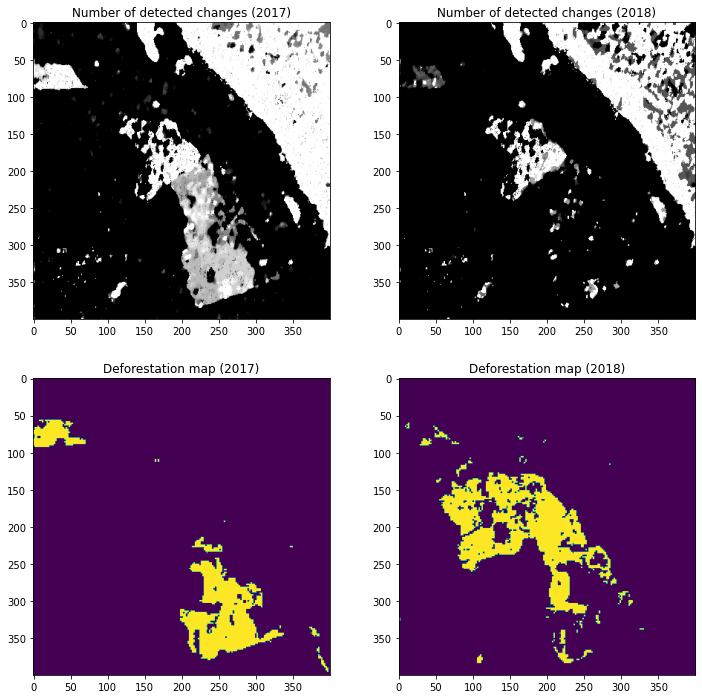

In [9]:
ch17 = change.sel(time='2017').sum('time')
ch18 = change.sel(time='2018').sum('time')

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
im17 = ch17.nd.to_rgb()#vmin=0, vmax=50)
ax[0, 0].imshow(im17)
ax[0, 0].set_title('Number of detected changes (2017)')
im18 = ch18.nd.to_rgb()#vmin=0, vmax=50)
ax[0, 1].imshow(im18)
ax[0, 1].set_title('Number of detected changes (2018)')
ax[1, 0].imshow(forest['lossyear'] == 17)
ax[1, 0].set_title('Deforestation map (2017)')
ax[1, 1].imshow(forest['lossyear'] == 18)
ax[1, 1].set_title('Deforestation map (2018)');

---
## References

[1] K. Conradsen, A. A. Nielsen and H. Skriver, "Determining the Points of Change in Time Series of Polarimetric SAR Data," in *IEEE Transactions on Geoscience and Remote Sensing*, vol. 54, no. 5, pp. 3007-3024, May 2016